# 迴歸(Regression)與時間序列(Time Series) 比較

## 安裝 Yahoo Finance API 套件

In [1]:
!pip install yfinance


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from datetime import date

## 下載 TSMC 股價

In [2]:
today = date.today().strftime("%Y-%m-%d")
df = yf.download("2330.TW", start="2015-01-01", end=today)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,140.5,140.5,137.5,139.5,105.174271,32046000
2015-01-06,137.5,137.5,133.0,133.5,100.650650,66778000
2015-01-07,133.5,135.0,133.5,134.0,101.027626,43703000
2015-01-08,136.5,138.0,136.0,138.0,104.043381,42491000
2015-01-09,135.0,135.5,133.0,134.0,101.027626,61558000


## 資料轉換

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2358 entries, 2015-01-05 to 2024-09-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2358 non-null   float64
 1   High       2358 non-null   float64
 2   Low        2358 non-null   float64
 3   Close      2358 non-null   float64
 4   Adj Close  2358 non-null   float64
 5   Volume     2358 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 129.0 KB


In [4]:
df_new = df[["Adj Close"]].copy()
df_new.columns = ["Close"]

## 繪圖

<Axes: xlabel='Date', ylabel='Close'>

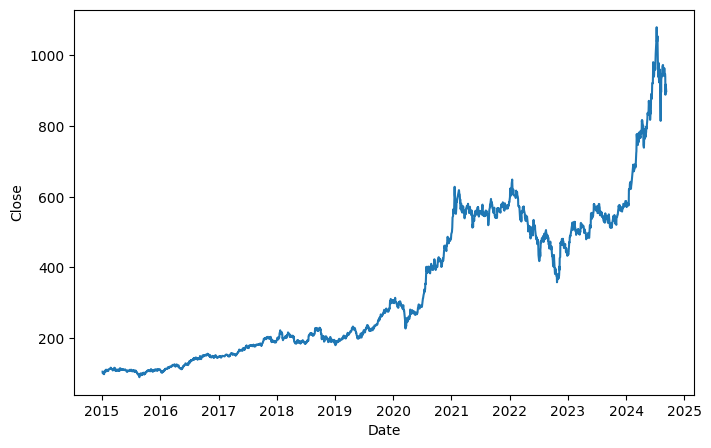

In [5]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=df_new.index, y="Close", data=df_new)

## 迴歸(Regression)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
X = np.arange(df_new.shape[0]).reshape(-1, 1)
y = df_new["Close"]
lr.fit(X, y)
pred = lr.predict(X)
print("MSE =", mean_squared_error(y, pred))

MSE = 7583.853664042583


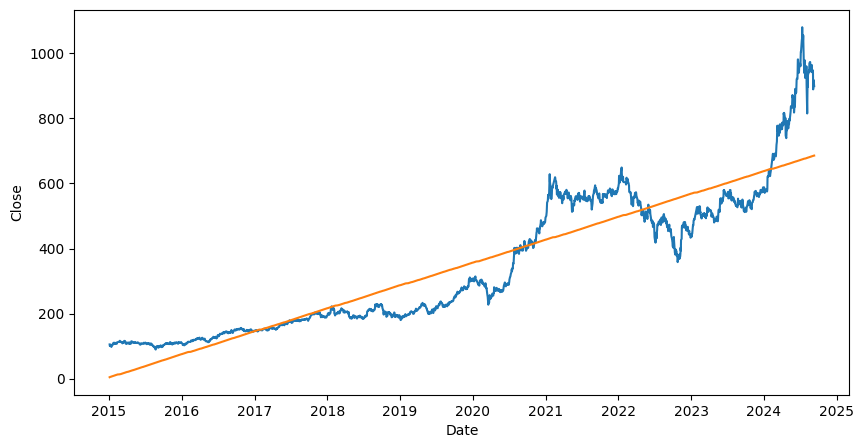

In [7]:
# 實際樣本點
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y="Close", data=df_new)

# 預測迴歸線
plt.plot(df.index, pred)

## 殘差線圖

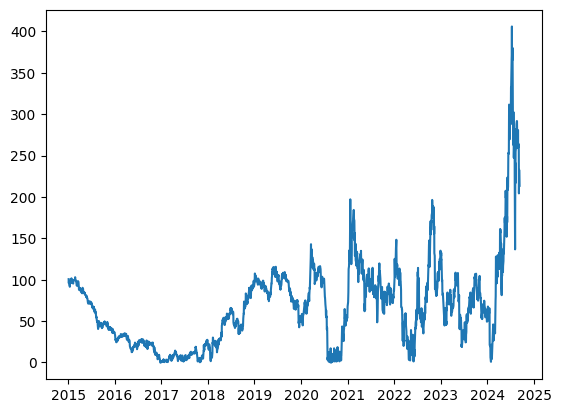

In [8]:
plt.plot(df_new.index, np.abs(df_new["Close"] - pred))

## 近兩年股價過大，與過去脫節，只擷取短期資料分析

In [9]:
df2 = df_new.query('index > "2020-01-01" and Close > 400')
df2.head()

,Close
Date,
2020-07-28,401.985229
2020-07-30,401.061096
2020-08-06,401.985229
2020-08-07,400.137054
2020-08-10,402.447266


<Axes: xlabel='Date', ylabel='Close'>

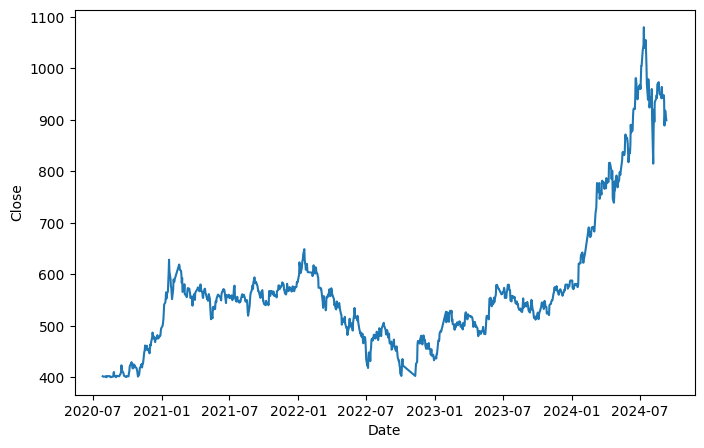

In [10]:
# 實際樣本點
plt.figure(figsize=(8, 5))
sns.lineplot(x=df2.index, y="Close", data=df2)

## 定態測試(Augmented Dickey–Fuller Test for Stationarity)

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df2["Close"])
print(
    f"ADF統計量: {result[0]}\np value: {result[1]}"
    + f"\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}"
)

ADF統計量: -0.4487378244932271
p value: 0.9016377891771028
滯後期數(Lags): 8
資料筆數: 953


## 結論：p > 0.05 ==> 非定態

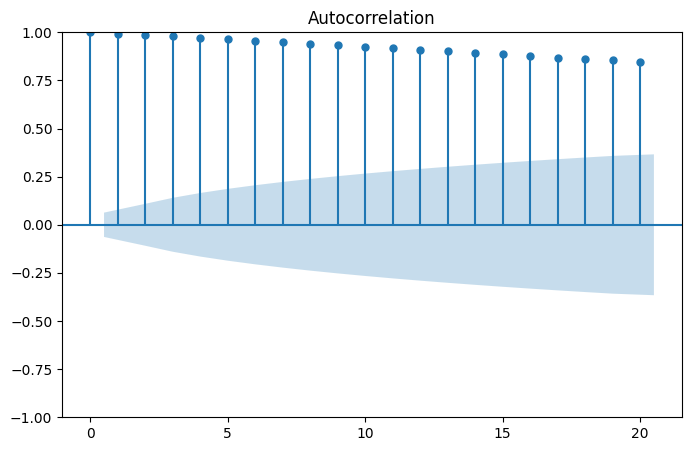

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(df2["Close"], lags=20)
fig.set_size_inches(8, 5)

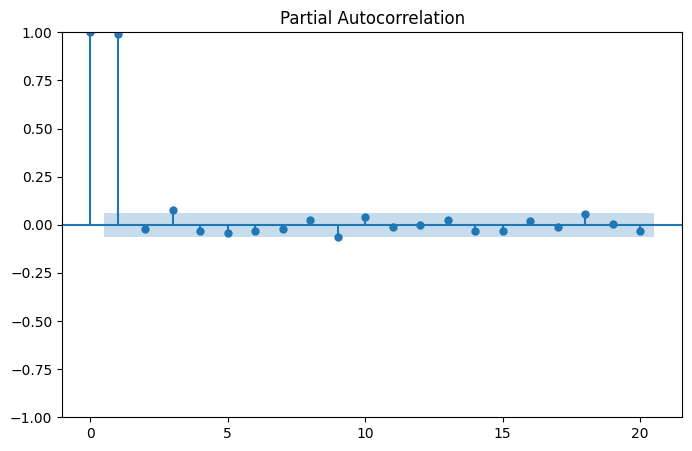

In [13]:
fig = plot_pacf(df2["Close"], lags=20, method="ywm")
fig.set_size_inches(8, 5)

## 時間序列(Time Series)

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 962 entries, 2020-07-28 to 2024-09-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   962 non-null    float64
dtypes: float64(1)
memory usage: 15.0 KB


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# 建立時間序列資料
series = df2.reset_index().copy().drop("Date", axis=1)

# AR(1) 模型訓練
ar = ARIMA(series, order=(1, 0, 0))  # , freq='D') 日期不連續會錯
model = ar.fit()

# 顯示模型訓練報告
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  962
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3682.096
Date:                Tue, 10 Sep 2024   AIC                           7370.191
Time:                        19:18:47   BIC                           7384.798
Sample:                             0   HQIC                          7375.753
                                - 962                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        574.4925    173.760      3.306      0.001     233.930     915.055
ar.L1          0.9983      0.002    574.522      0.000       0.995       1.002
sigma2       122.8882      2.538     48.425      0.0

In [16]:
model.params

const     574.492512
ar.L1       0.998338
sigma2    122.888230
dtype: float64

In [17]:
df["Close"].mean()

372.7224342663274

## 繪圖比較實際值與預測值

In [18]:
model.fittedvalues

0      574.492512
1      402.271916
2      401.349319
3      402.271916
4      400.426813
          ...    
957    947.379275
958    939.392570
959    888.477326
960    901.455721
961    917.429131
Length: 962, dtype: float64

In [19]:
pred = pd.Series(data=model.fittedvalues.values, index=df2.index)
# 第一筆無法預測，故設定與第二筆相同，避免繪圖很突兀
pred.iloc[0] = pred.iloc[1]
pred

Date
2020-07-28    402.271916
2020-07-30    402.271916
2020-08-06    401.349319
2020-08-07    402.271916
2020-08-10    400.426813
                 ...    
2024-09-03    947.379275
2024-09-04    939.392570
2024-09-05    888.477326
2024-09-06    901.455721
2024-09-09    917.429131
Length: 962, dtype: float64

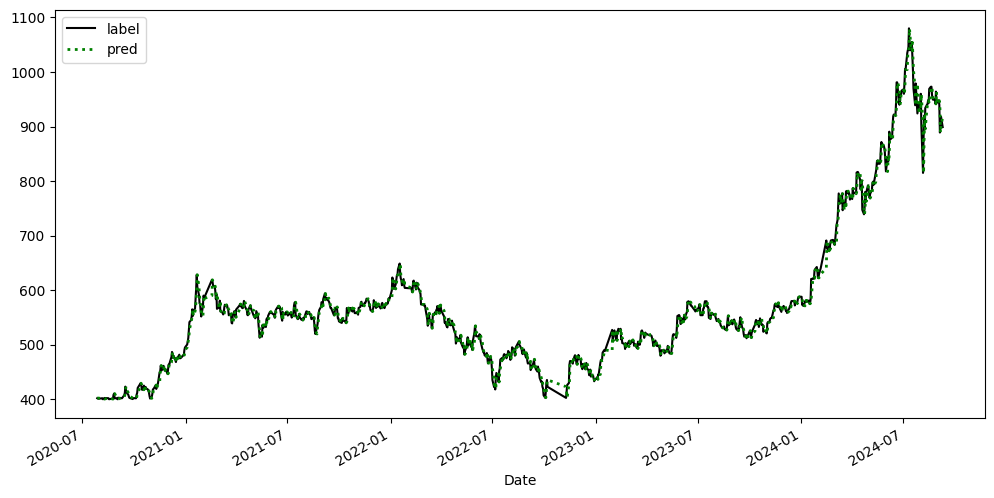

In [20]:
series.index = df2.index
series["Close"].plot(figsize=(12, 6), color="black", linestyle="-", label="label")
pred.plot(figsize=(12, 6), color="green", linestyle=":", lw=2, label="pred")
plt.legend()

In [21]:
print(f"AR MSE = {(np.sum(model.resid**2) / len(model.resid)):.2f}")

AR MSE = 153.72


## AR(1) 殘差(residual)繪圖

<Axes: >

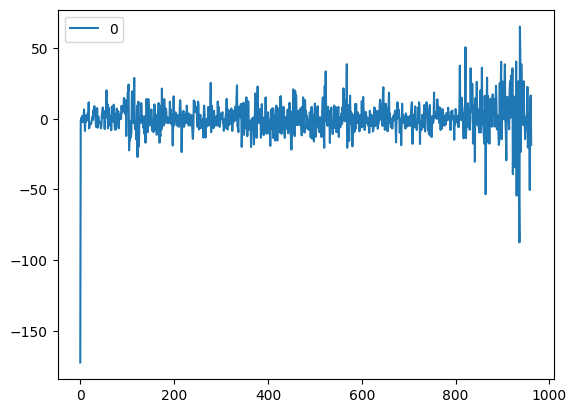

In [22]:
residuals = pd.DataFrame(model.resid)
residuals.plot()

## 資料分割

In [23]:
test_size = 30

from sklearn.model_selection import train_test_split

# 資料分割
X_train, X_test = train_test_split(series, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((932, 1), (30, 1))

## 模型訓練、預測與繪圖

In [24]:
len(pred)

962

/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/chesterxalan/github/Classwor

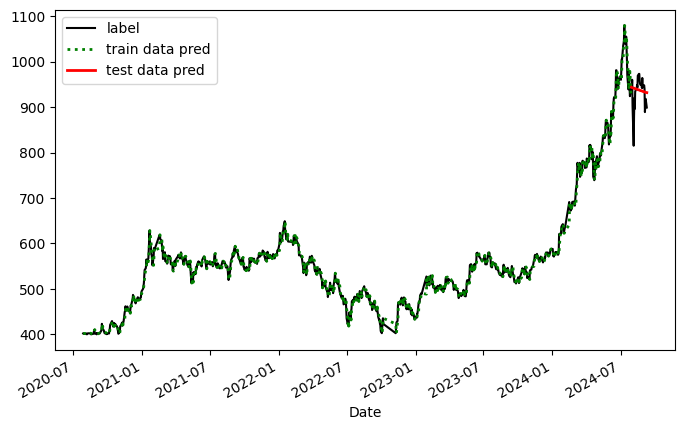

In [25]:
# AR(1) 模型訓練
ar_1 = ARIMA(X_train[["Close"]], order=(1, 0, 0))
model_1 = ar_1.fit()

# 預測 30 天
pred = model_1.predict(X_train.shape[0], X_train.shape[0] + test_size - 1)

series["Close"].plot(color="black", linestyle="-", label="label")
train_pred = pd.Series(
    data=model_1.fittedvalues.values, index=df2.index[: X_train.shape[0]]
)
# 第一筆無法預測，故設定與第二筆相同，避免繪圖很突兀
train_pred.iloc[0] = train_pred.iloc[1]
train_pred.plot(color="green", linestyle=":", lw=2, label="train data pred")
test_pred = pd.Series(data=pred.values, index=df2.index[X_train.shape[0] :])
test_pred.plot(figsize=(8, 5), color="red", lw=2, label="test data pred")
plt.legend()

# 改用 SARIMAX (Seasonal ARIMA) 演算法

## 一次差分(First-order Differencing)

<Axes: xlabel='Date'>

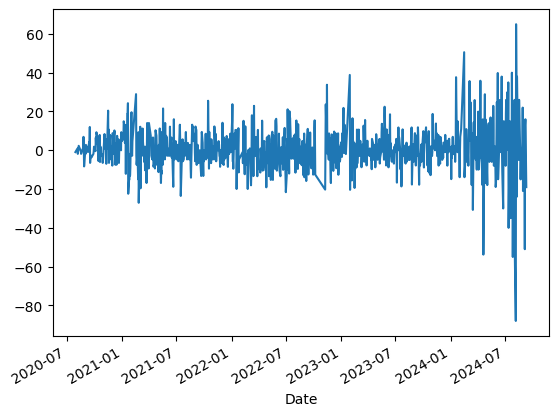

In [26]:
df_diff = df2.copy()
df_diff["diff"] = df_diff["Close"] - df_diff["Close"].shift(1)
df_diff.dropna(inplace=True)
df_diff["diff"].plot()

## 使用ADF檢定

In [27]:
result = adfuller(df_diff["diff"])
print(
    f"ADF統計量: {result[0]}\np value: {result[1]}"
    + f"\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}"
)

ADF統計量: -10.20390375543897
p value: 5.8724687845742516e-18
滯後期數(Lags): 7
資料筆數: 953


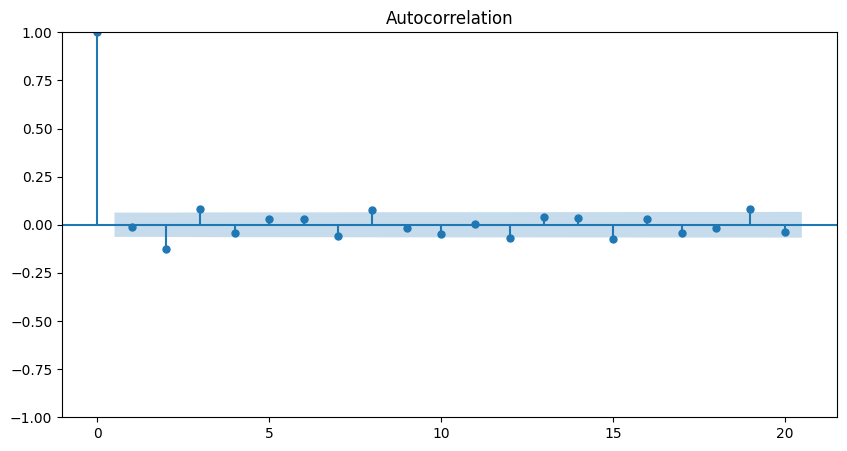

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(df_diff["diff"], lags=20)
fig.set_size_inches(10, 5)

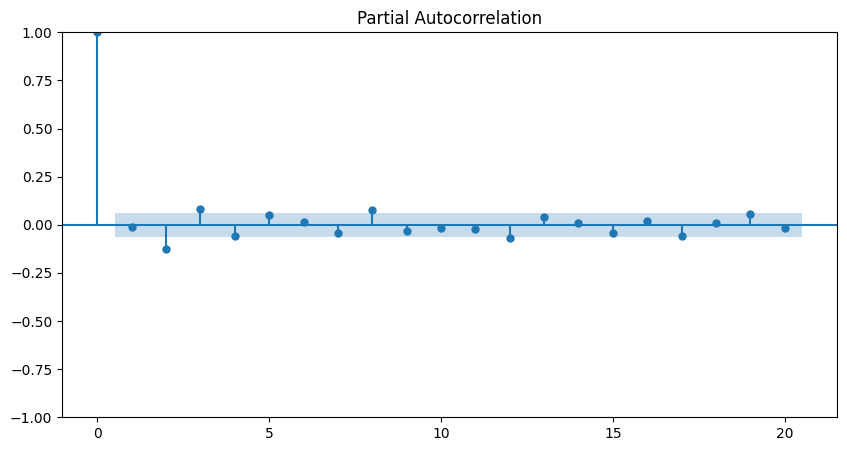

In [29]:
fig = plot_pacf(df_diff["diff"], lags=20, method="ywm")
fig.set_size_inches(10, 5)

## SARIMAX

In [30]:
# 預測 30 天
pred_period = 30

# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=pred_period, shuffle=False)

# SARIMAX
import statsmodels.api as sm

ar_diff = sm.tsa.statespace.SARIMAX(
    X_train[["Close"]], order=(1, 2, 1), seasonal_order=(1, 2, 1, 10)
)
model_diff = ar_diff.fit()

pred = model_diff.predict(
    X_train.shape[0], X_train.shape[0] + pred_period - 1, dynamic=True
)
pred[:10]

/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26244D+00    |proj g|=  6.57376D-02

At iterate    5    f=  3.94986D+00    |proj g|=  2.80570D-01

At iterate   10    f=  3.86243D+00    |proj g|=  1.48748D-02

At iterate   15    f=  3.85969D+00    |proj g|=  1.64300D-03

At iterate   20    f=  3.85740D+00    |proj g|=  8.72618D-03

At iterate   25    f=  3.85644D+00    |proj g|=  7.68264D-03

At iterate   30    f=  3.85627D+00    |proj g|=  1.85604D-04

At iterate   35    f=  3.85624D+00    |proj g|=  4.94183D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.85624D+00    |proj g|=  1.03916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     67      2     0     0   5.655D-05   3.856D+00
  F =   3.8562349882896161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/chesterxalan/github/Classwork/Classwork-PythonMLApplicationDevelopment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


931    927.168122
932    927.923325
933    930.803619
934    928.142803
935    929.149309
936    911.572975
937    911.578883
938    933.623861
939    908.965411
940    936.880434
Name: predicted_mean, dtype: float64

## 繪圖

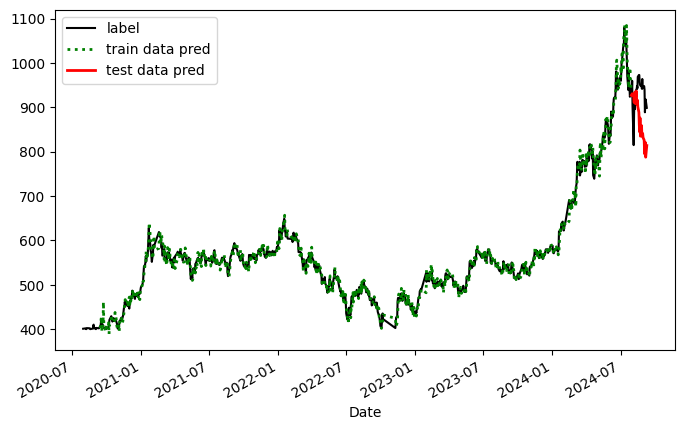

In [31]:
df_diff["Close"].plot(color="black", linestyle="-", label="label")
model_diff.fittedvalues.iloc[15:].plot(
    color="green", linestyle=":", lw=2, label="train data pred"
)
test_pred = pd.Series(data=pred.values, index=df_diff.index[X_train.shape[0] :])
test_pred.plot(figsize=(8, 5), color="red", lw=2, label="test data pred")
plt.legend()

In [32]:
print(f"SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}")

SARIMAX MSE = 542.52


## 結論：SARIMAX 準確率比迴歸高
### 時間序列 MSE： 427， 迴歸 MSE： 2091

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 962 entries, 2020-07-28 to 2024-09-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   962 non-null    float64
dtypes: float64(1)
memory usage: 15.0 KB


In [34]:
date1 = pd.date_range(start=df2.index[0], end=df2.index[-1])
df_continue = pd.DataFrame(index=date1)
df_continue = df_continue.join(df2)
df_continue = df_continue.ffill()
df_continue.head()

,Close
2020-07-28,401.985229
2020-07-29,401.985229
2020-07-30,401.061096
2020-07-31,401.061096
2020-08-01,401.061096


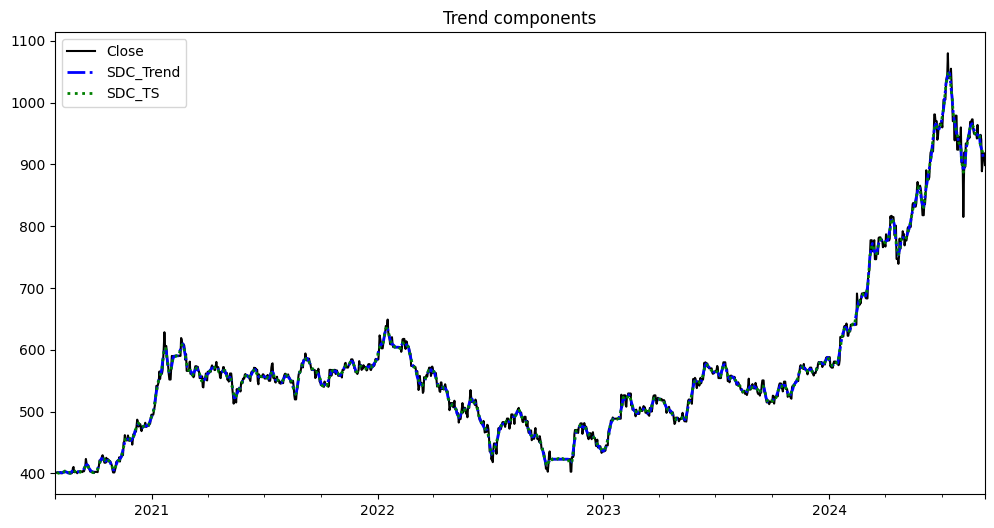

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = df_continue
s_dc = seasonal_decompose(decomp["Close"], model="additive")
decomp["SDC_Seasonal"] = s_dc.seasonal
decomp["SDC_Trend"] = s_dc.trend
decomp["SDC_Error"] = s_dc.resid
decomp["SDC_TS"] = s_dc.trend + s_dc.seasonal


plt.title("Trend components")
decomp["Close"].plot(figsize=(12, 6), color="black", linestyle="-", legend="Close")
decomp["SDC_Trend"].plot(
    figsize=(12, 6), color="blue", linestyle="-.", lw=2, legend="SDC_Trend"
)
decomp["SDC_TS"].plot(figsize=(12, 6), color="green", linestyle=":", lw=2, legend="TS");

## 效應分解(Decomposition)

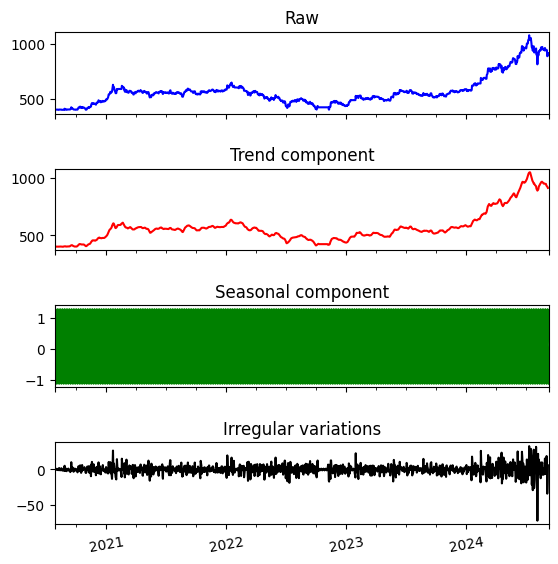

In [36]:
# Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

decomp["Close"].plot(ax=axarr[0], color="b", linestyle="-")
axarr[0].set_title("Raw")

pd.Series(data=decomp["SDC_Trend"], index=decomp.index).plot(
    color="r", linestyle="-", ax=axarr[1]
)
axarr[1].set_title("Trend component")

pd.Series(data=decomp["SDC_Seasonal"], index=decomp.index).plot(
    color="g", linestyle="-", ax=axarr[2]
)
axarr[2].set_title("Seasonal component")

pd.Series(data=decomp["SDC_Error"], index=decomp.index).plot(
    color="k", linestyle="-", ax=axarr[3]
)
axarr[3].set_title("Irregular variations")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
fig = plt.xticks(rotation=10)

In [37]:
MSE = (decomp["SDC_Error"] ** 2).sum() / decomp["SDC_Error"].shape[0]
"MSE=", MSE

('MSE=', 42.25424945626741)

## 結論：時間序列預測準確率比迴歸高
### 時間序列 MSE： 27， 迴歸 MSE： 5032